In [38]:
import sqlalchemy as sa
import pandas as pd

# SQLAlchemy engine using pyodbc driver
engine = sa.create_engine(
    "mssql+pyodbc://@HARI\\SQLEXPRESS/banking_db?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes"
)


In [11]:
customers = pd.read_sql("SELECT * FROM customers", engine)
accounts = pd.read_sql("SELECT * FROM accounts", engine)
transactions = pd.read_sql("SELECT * FROM transactions", engine)
loans = pd.read_sql("SELECT * FROM loans", engine)

print("✅ Data Loaded Successfully")


✅ Data Loaded Successfully


In [12]:
print("\n--- Customers ---")
print(customers.head())
print(customers.info())

print("\n--- Accounts ---")
print(accounts.head())
print(accounts.info())

print("\n--- Transactions ---")
print(transactions.head())
print(transactions.info())

print("\n--- Loans ---")
print(loans.head())
print(loans.info())


--- Customers ---
   customer_id        name         dob       city  contact_no
0         1001  Customer_1  2003-06-14  Bangalore  9103633818
1         1002  Customer_2  1999-11-07    Chennai  9833858968
2         1003  Customer_3  1990-11-14     Mumbai  9216297320
3         1004  Customer_4  1986-10-12  Ahmedabad  9820192544
4         1005  Customer_5  1971-01-23      Delhi  9335108735
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  100 non-null    int64 
 1   name         100 non-null    object
 2   dob          100 non-null    object
 3   city         100 non-null    object
 4   contact_no   100 non-null    object
dtypes: int64(1), object(4)
memory usage: 4.0+ KB
None

--- Accounts ---
   account_id  customer_id   account_type   balance opened_date
0        2001         1001        Savings  68246.82        None
1        2002     

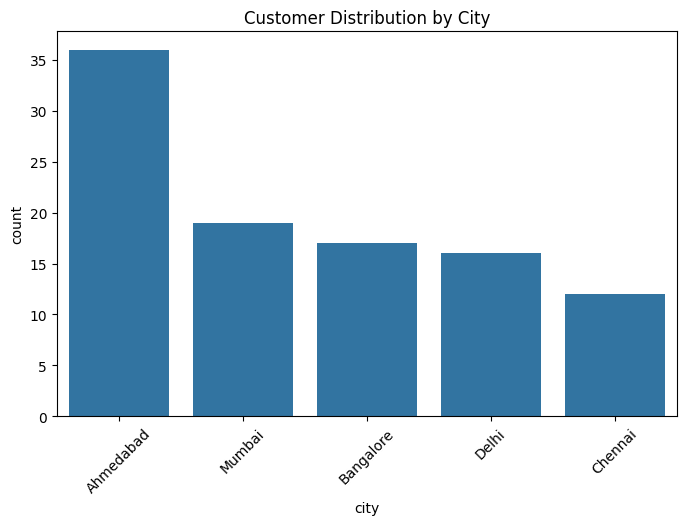

In [14]:
import sqlalchemy as sa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Customer Demographics:
plt.figure(figsize=(8,5))
sns.countplot(data=customers, x='city', order=customers['city'].value_counts().index)
plt.title("Customer Distribution by City")
plt.xticks(rotation=45)
plt.show()

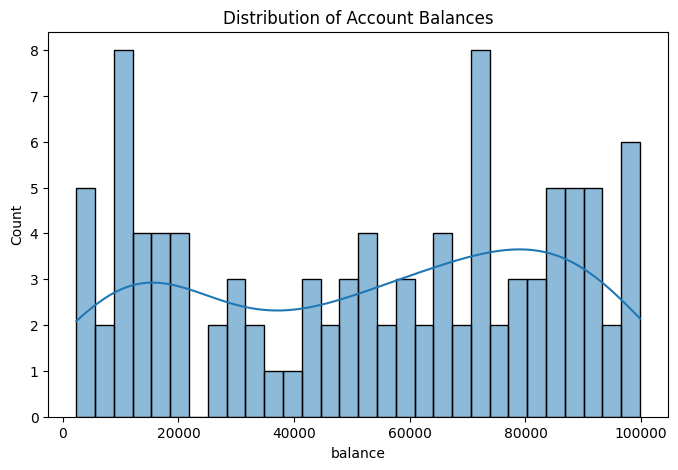

In [16]:
#Account Balance Distribution
plt.figure(figsize=(8,5))
sns.histplot(accounts['balance'], bins=30, kde=True)
plt.title("Distribution of Account Balances")
plt.show()

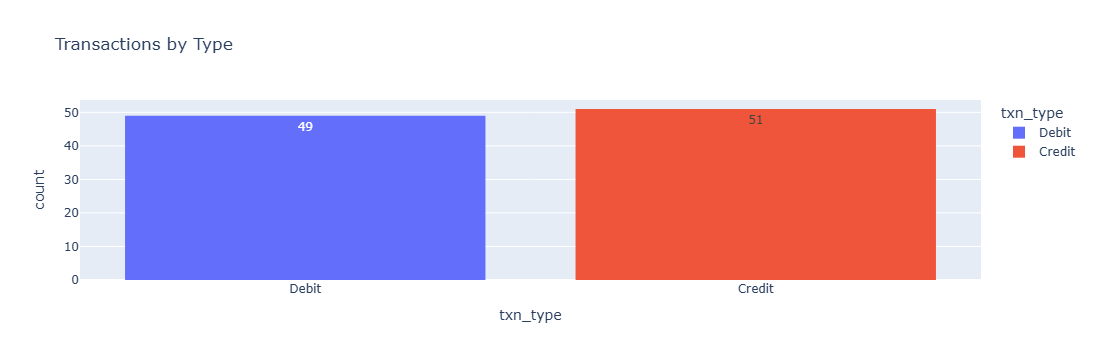

In [17]:
## Transactions by Type (Interactive)
fig = px.histogram(transactions, x="txn_type", color="txn_type",
                   title="Transactions by Type", text_auto=True)
fig.show()

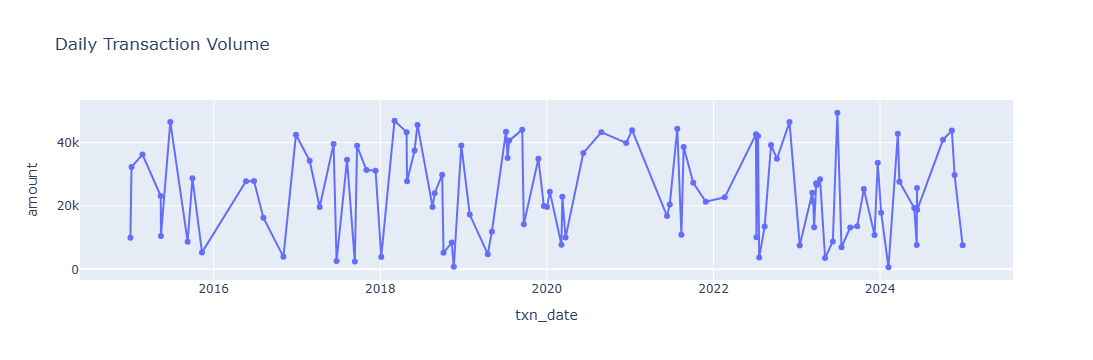

In [19]:
# Ensure txn_date is datetime
transactions['txn_date'] = pd.to_datetime(transactions['txn_date'], errors='coerce')

# Now group by date
txn_daily = transactions.groupby(transactions['txn_date'].dt.to_period("D"))['amount'].sum().reset_index()

# Convert period back to string for Plotly
txn_daily['txn_date'] = txn_daily['txn_date'].astype(str)

# Plot
import plotly.express as px
fig = px.line(txn_daily, x="txn_date", y="amount", title="Daily Transaction Volume", markers=True)
fig.show()


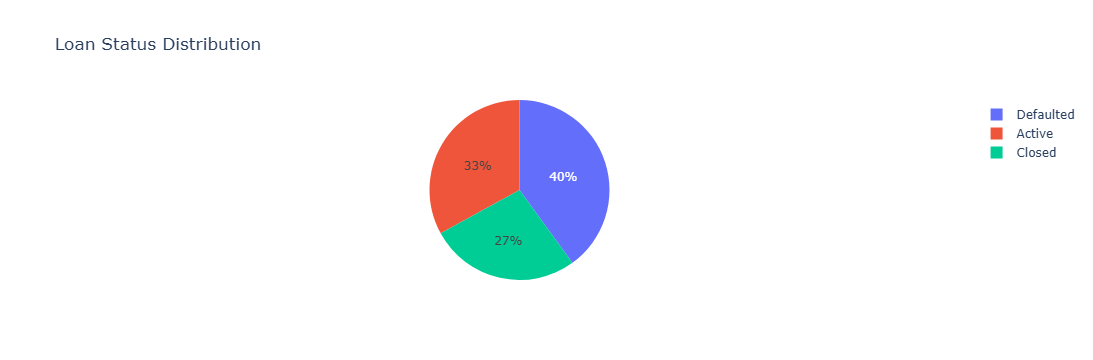

In [20]:
## 4.5 Loan Status Breakdown
fig = px.pie(loans, names='status', title="Loan Status Distribution")
fig.show()

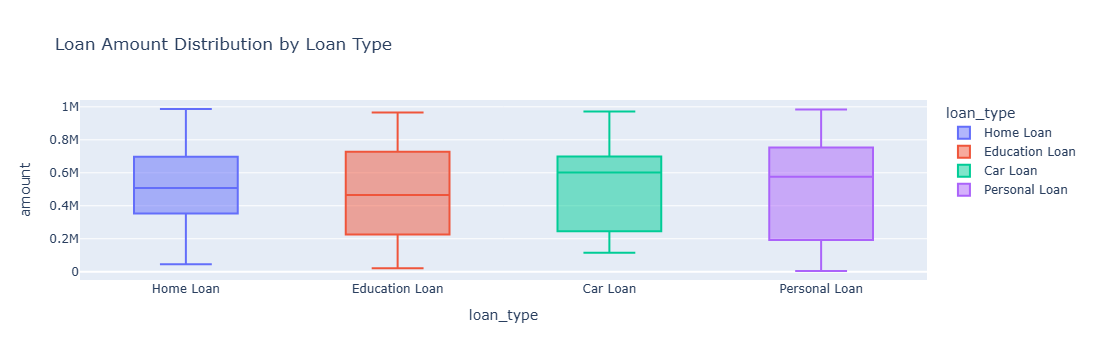

In [21]:
## 4.6 Loan Amount by Type
fig = px.box(loans, x="loan_type", y="amount", color="loan_type",
             title="Loan Amount Distribution by Loan Type")
fig.show()

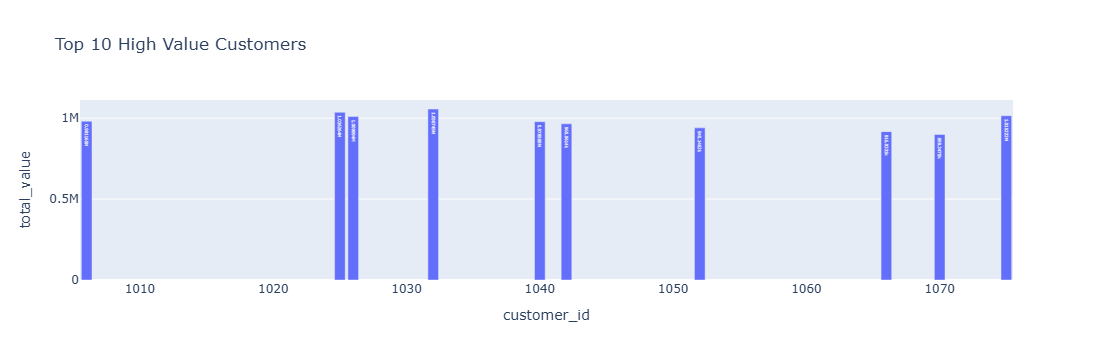

In [22]:
## 4.7 Top 10 High Value Customers (Total Balance + Loans)
cust_finance = accounts.groupby('customer_id')['balance'].sum().reset_index()
cust_loans = loans.groupby('customer_id')['amount'].sum().reset_index()
cust_total = pd.merge(cust_finance, cust_loans, on="customer_id", how="outer").fillna(0)
cust_total['total_value'] = cust_total['balance'] + cust_total['amount']
top_customers = cust_total.sort_values('total_value', ascending=False).head(10)

fig = px.bar(top_customers, x="customer_id", y="total_value",
             title="Top 10 High Value Customers", text_auto=True)
fig.show()

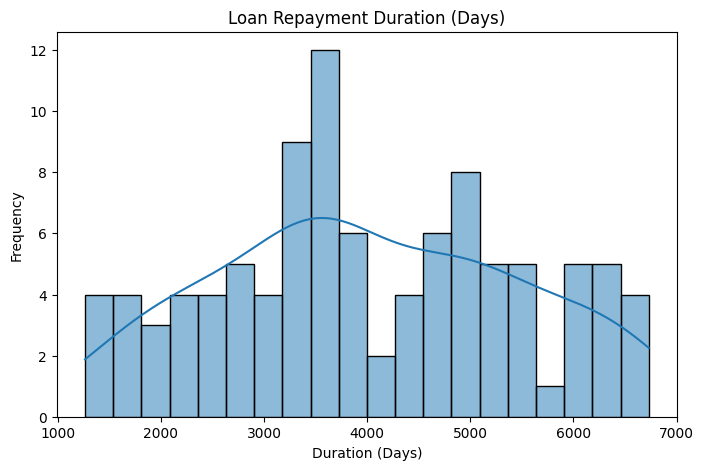

In [24]:
# Ensure both columns are datetime
loans['start_date'] = pd.to_datetime(loans['start_date'], errors='coerce')
loans['end_date'] = pd.to_datetime(loans['end_date'], errors='coerce')

# Calculate repayment duration in days
loans['duration_days'] = (loans['end_date'] - loans['start_date']).dt.days

# Plot repayment duration distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(loans['duration_days'], bins=20, kde=True)
plt.title("Loan Repayment Duration (Days)")
plt.xlabel("Duration (Days)")
plt.ylabel("Frequency")
plt.show()


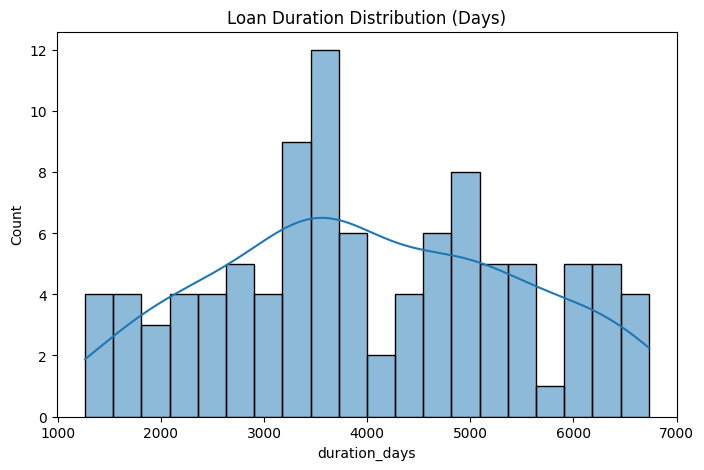

In [25]:
## 4.8 Loan Repayment Duration
loans['duration_days'] = (loans['end_date'] - loans['start_date']).dt.days
plt.figure(figsize=(8,5))
sns.histplot(loans['duration_days'], bins=20, kde=True)
plt.title("Loan Duration Distribution (Days)")
plt.show()


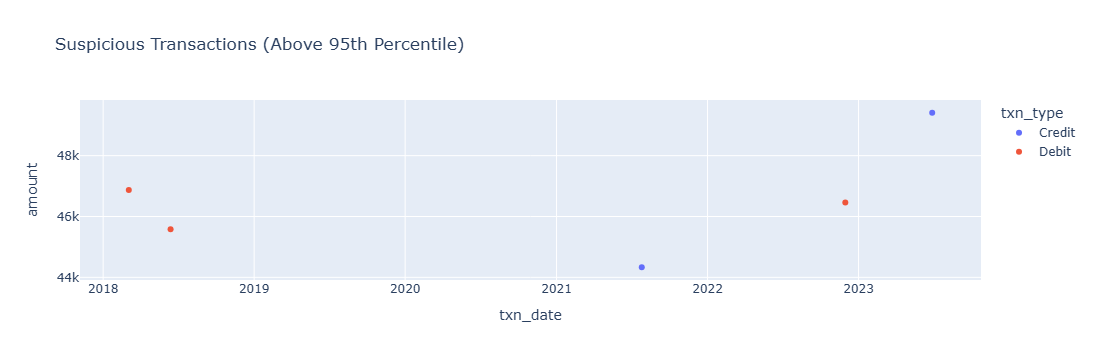

In [27]:
 ##4.9 Fraud Detection (Suspicious Transactions > 95th percentile)
threshold = transactions['amount'].quantile(0.95)
suspicious_txn = transactions[transactions['amount'] > threshold]

fig = px.scatter(suspicious_txn, x="txn_date", y="amount", color="txn_type",
                 title="Suspicious Transactions (Above 95th Percentile)", hover_data=['account_id'])
fig.show()

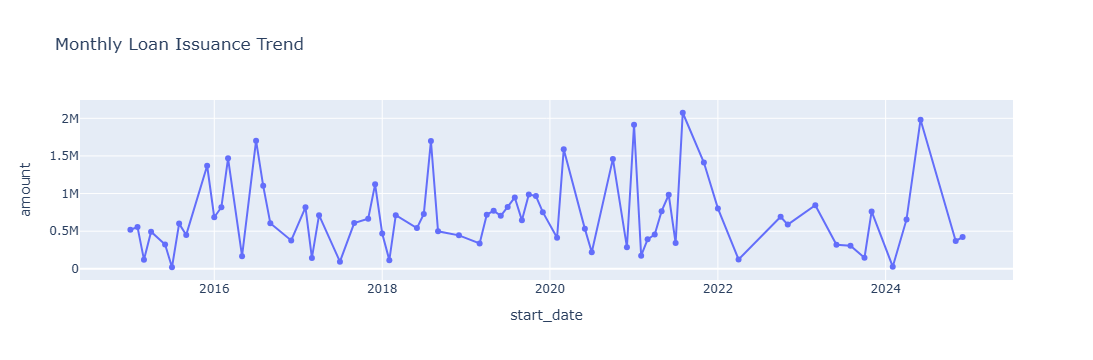

In [28]:
## 4.10 Monthly Loan Issuance Trend
loan_trend = loans.groupby(loans['start_date'].dt.to_period("M"))['amount'].sum().reset_index()
loan_trend['start_date'] = loan_trend['start_date'].astype(str)

fig = px.line(loan_trend, x="start_date", y="amount",
              title="Monthly Loan Issuance Trend", markers=True)
fig.show()

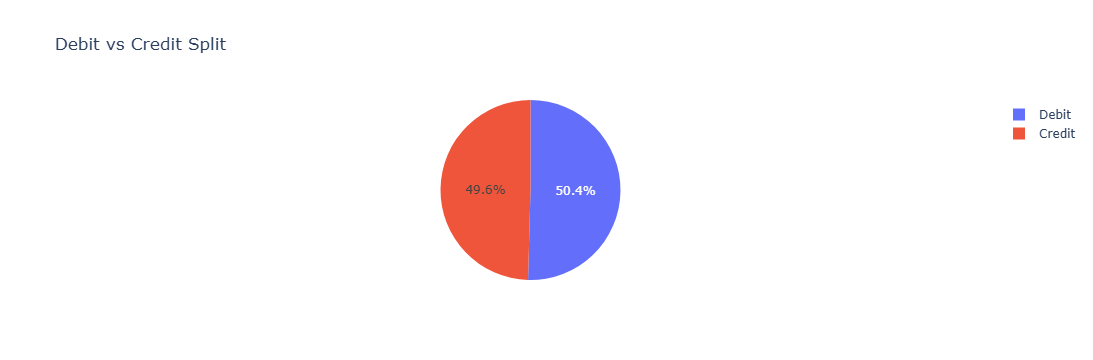

In [29]:
##Debit vs Credit Transactions
txn_type_summary = transactions.groupby("txn_type")['amount'].sum().reset_index()

import plotly.express as px
fig = px.pie(txn_type_summary, names="txn_type", values="amount", title="Debit vs Credit Split")
fig.show()

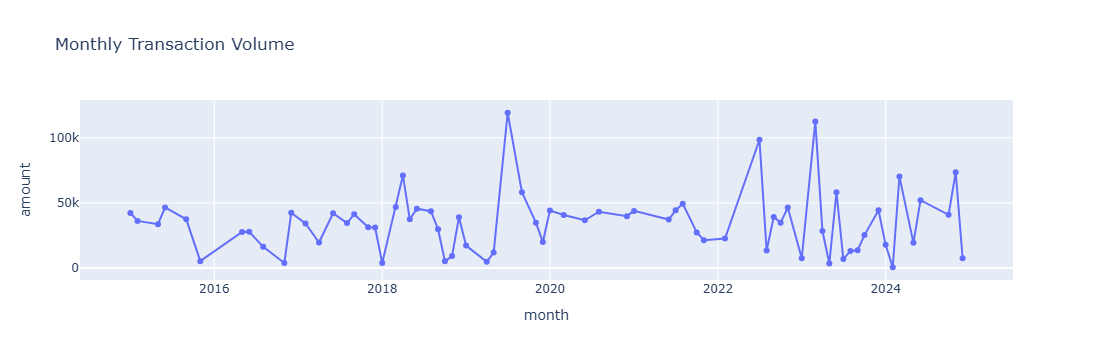

In [32]:
# Convert txn_date to datetime
transactions['txn_date'] = pd.to_datetime(transactions['txn_date'], errors='coerce')

# Extract month as first day of the month (datetime) OR string
transactions['month'] = transactions['txn_date'].dt.to_period('M').dt.to_timestamp()

# Group by month
txn_monthly = transactions.groupby("month")['amount'].sum().reset_index()

import plotly.express as px
fig = px.line(txn_monthly, x="month", y="amount",
              title="Monthly Transaction Volume", markers=True)
fig.show()


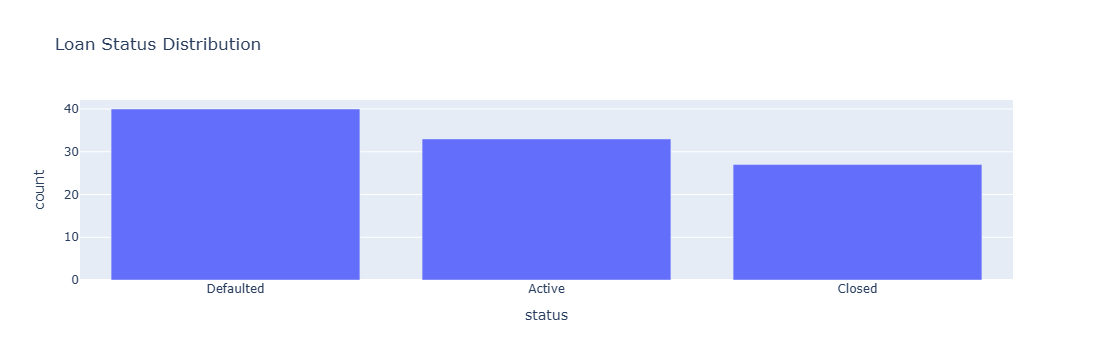

In [33]:
##Loan Status Distribution
loan_status = loans['status'].value_counts().reset_index()
loan_status.columns = ['status', 'count']

fig = px.bar(loan_status, x="status", y="count", title="Loan Status Distribution")
fig.show()

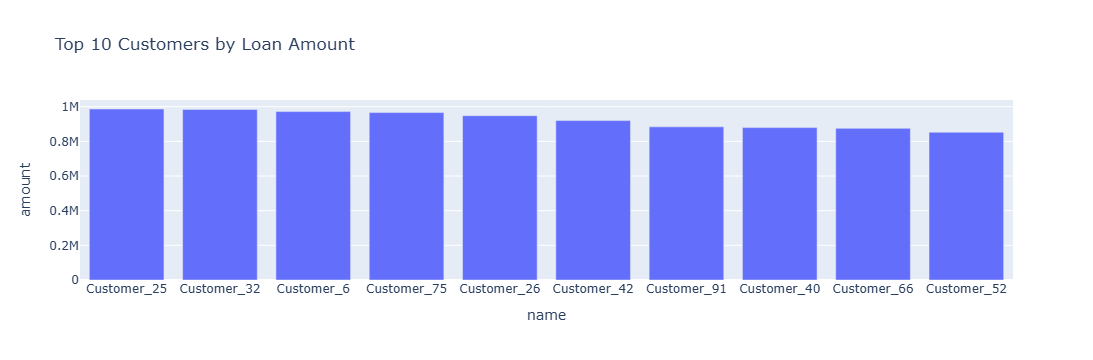

In [36]:
##Top 10 Customers by Loan Amount
loan_customers = loans.merge(customers, on="customer_id")

top_loans = (
    loan_customers.groupby("name")['amount']
    .sum()
    .nlargest(10)
    .reset_index()
)

import plotly.express as px
fig = px.bar(top_loans, x="name", y="amount",
             title="Top 10 Customers by Loan Amount")
fig.show()
